# *Capstone Project - Machine Learning Nanodegree Udacity*

## Desafio *Kaggle* - Porto Seguro

### Importando libs

In [3]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVR

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold

from time import time

### Leitura da base 

In [2]:
data = pd.read_csv('train/train.csv', na_values="-1")
print(data.shape)

(595212, 59)


In [ ]:
data.head()

#### variável target tem 3,64% de incidência na base.

In [ ]:
count = pd.DataFrame(data['target'].value_counts())
percent = pd.DataFrame(data['target'].value_counts(normalize=True)*100)
table = pd.concat([count, percent], axis=1)
table.columns = ['# target', '% target']
table

#### separação em base treino e base teste

In [ ]:
from sklearn.model_selection import train_test_split

#id_all = 
X_all = data.iloc[:,2:]
y_all = data.target

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.30 ,random_state = 791231)

print "Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1])
print "Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1])


#### criando variável de quantidade de missing

In [ ]:
temp = X_train.isnull().sum(axis=1)
X_train.loc[:,'n_miss']=temp
X_train.n_miss.value_counts(normalize=True)

table = pd.crosstab(X_train.n_miss, y_train)
sum_line = table.apply(lambda x:x.sum(),axis = 1)
p_target = table.iloc[:,1]/sum_line
p_total = sum_line / sum((sum(table.iloc[:,0]), sum(table.iloc[:,1])))
df = pd.concat([p_total, p_target ], axis=1)
df.columns = ['% cat', '% target']
print(df)

#### Métrica gini normalizado será utilizada para avaliação do modelo

In [ ]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p[:,1]) / gini(a, a)        

In [ ]:
def gini_normalized_xgboost(a, p):
    return gini(a, p) / gini(a, a)        

### Explorando os dados
#### Criando uma base com a quantidade de valores únicos de cada variável e percentual de *missings*:

Sobre a quantidade de valores é possível observar:
- algumas variáveis categóricas possuem grande quantidade de categorias: *ps_car_06_cat*, *ps_car_11_cat*, com 18 e 104 categorias respectivamente. Essas não terão tratamento de dummies mais pra frente para o processo de modelagem pois aumentariam muito o número de colunas.
- As variáveis categóricas e seu percentual da variável resposta serão analisados mais pra frente graficamente.

In [ ]:
#count unique values in columns and plot
len_array = []
for var in X_train.columns:
    current_len  = len(X_train[var].unique())
    len_array.append(current_len)

missing = pd.DataFrame(np.array(X_train.isnull().sum()), columns = ['missing'])
p_missing = missing / X_train.shape[0]

qtd = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(len_array), missing.missing, pd.DataFrame(p_missing)], axis = 1)
qtd.columns = ['var', '# unique values', '# missing','% missing']

qtd.iloc[:,0:2 ]

Sobre os *missings*:
- temos 13 variáveis com alguma quantidade de missings;
- das variáveis categóricas: *ps_car_03_cat* possui 70% de missings e em seguida *ps_car_05_cat* com 45% de missings.
- das não categóricas *ps_reg_03* e *ps_car_14* com 18% e 7%, respectivamente.

Forma de tratamento:
- no caso das categóricas preenchimento com um outro número (99) representando a categoria missing (avaliaremos graficamente se faz sentido mantê-las separadas);
- no caso das numéricas aplicação da média e mediana.

In [ ]:
qtd = qtd.sort_values(by = '% missing', ascending = False)
print(qtd.iloc[0:15,:])

fig = plt.figure()
plt.style.use('ggplot')
ax1 = fig.add_subplot(111)
qtd.iloc[0:15,3].plot(kind = 'bar',ax=ax1)
ax1.set_xticklabels(qtd.iloc[0:15,0], rotation='45', fontsize=12)

plt.show()

#### Utilizando a orientação, realizando separação das variáveis binárias, das categóricas e das demais para respectivos tratamentos de *missings* e outras análises gráficas.


In [ ]:
x_cols = np.array(X_train.columns)
names_bin = filter(lambda x: x.endswith('_bin'), x_cols)
names_cat = filter(lambda x: x.endswith('_cat'), x_cols)
names_others = filter(lambda x: not x in names_cat + names_bin, x_cols)

print(names_cat) 
print('\n')
print(names_bin)
print('\n')
print(names_others)

Ajustando todas categóricas ou binárias para 99.

In [ ]:
for var in names_cat:
    X_train.loc[:, var] = X_train.loc[:,var].fillna(999)
for var in names_bin:
    X_train.loc[:, var] = X_train.loc[:,var].fillna(999)

No caso da ps_reg_03 ajustado missing para a mediana

In [ ]:
med_ps_reg03 = X_train['ps_reg_03'].median()

X_train['ps_reg_03_MED'] = X_train['ps_reg_03'].fillna(med_ps_reg03)


As demais variáveis numéricas que apareceram na base serão substituídas pela respectiva mediana da coluna.

In [ ]:
train_median =  X_train.apply(lambda x: x.median(), axis = 0)
for i in range(len(X_train.columns)):
    X_train.iloc[:, i] = X_train.iloc[:, i].fillna(train_median[i])

### Visualização exploratória: "Porto Seguro - Descritivas.ipynb"


#### agrupamento da variável *ps_car_11_cat* 
Dado a alta quantidade de categorias, será testado no modelo sua entrada como numérica e também com um agrupamento considerando a variável target, com valores de 1 a 10.

In [15]:
def transf_car11cat (elemento):
    if elemento in [41,18,75,63,58]:
        return 1
    elif elemento in [56, 93,71,69, 21,97,55,72,4,33,100,89, 3, 94]:
        return 2
    elif elemento in [61, 13, 17, 20, 14, 90,104]:
        return 3
    elif elemento in [54, 45, 50, 28, 1, 79, 5, 31, 73, 80, 47, 2, 12]:
        return 4
    elif elemento in [12, 27, 8, 25, 24, 6, 46, 101, 91, 92, 81, 70, 29]:
        return 5
    elif elemento in [76, 83, 35, 15, 78, 36, 77, 34, 52, 40, 23]:
        return 6
    elif elemento in [51, 102, 26, 59, 22, 68, 60, 49, 87, 74, 53, 88, 85, 86, 84, 48, 96, 9]:
        return 7
    elif elemento in [38, 11, 62, 65, 98, 64, 37, 42, 95]:
        return 8
    elif elemento in [66, 7, 30, 82, 103, 16, 10, 44]:
        return 9
    elif elemento in [32, 57, 67, 39, 99, 19, 43]:
        return 10
    else:
        return 10

X_train['ps_car_11_cat_v2'] = map(transf_car11cat , X_train['ps_car_11_cat'])
#print(X_train['ps_car_11_cat_v2'].value_counts())
#print(X_train['ps_car_11_cat'].value_counts())




C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### quais variáveis serão dummizadas -> exclusão das que possuem muitas categorias

In [16]:
exclusao_dummies  = ['ps_car_11_cat','ps_car_06_cat','ps_car_01_cat']                  
                    
names_to_dummies = names_cat
#new_columns = ['ps_car_06_cat_v2',  'ps_car_04_cat_v2', 'ps_car_01_cat_v2','n_miss_v2']

names_to_dummies2 = filter(lambda x: x not in exclusao_dummies, names_to_dummies)
print(names_to_dummies2)

X_train = pd.get_dummies(X_train, columns = names_to_dummies2)
#print(X_train.columns)


['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']


#### Método para limpar colunas da base treino identificando as variáveis categóricas com variância próxima de zero, no caso todas em que a relação entre a primeira e segunda categoria é de 99 para 1.

In [17]:
def nearZeroVariance (v, freqCut, uniqueCut = 0.10):
    if len (v.value_counts()) == 1:
        return True
    mostFrequent = v.value_counts()[v.value_counts().keys()[0]]
    secondMostFrequent = v.value_counts()[v.value_counts().keys()[1]]
    if mostFrequent / secondMostFrequent >= freqCut and len (v.value_counts()) / len (v) <= uniqueCut:
            return True
    return False


    #print(i, nzv)

In [18]:
array_nzv = []
for i in X_train.columns:
    nzv = nearZeroVariance (X_train[i],freqCut = 99/1, uniqueCut = 0.005)
    array_nzv.append(nzv)
    
    
nzv_df = pd.DataFrame(array_nzv, index= X_train.columns, columns = ['nzv'])
true_nzv = nzv_df[nzv_df['nzv'] == True]
print('columns will be dropped:')
print(true_nzv)
print(len(true_nzv))
#true_nzv.index

columns will be dropped:
                      nzv
ps_ind_10_bin        True
ps_ind_11_bin        True
ps_ind_12_bin        True
ps_ind_13_bin        True
ps_ind_14            True
ps_reg_03            True
ps_reg_03_MED        True
ps_ind_02_cat_999.0  True
ps_ind_04_cat_999.0  True
ps_ind_05_cat_2.0    True
ps_ind_05_cat_5.0    True
ps_ind_05_cat_999.0  True
ps_car_02_cat_999.0  True
ps_car_04_cat_3      True
ps_car_04_cat_4      True
ps_car_04_cat_5      True
ps_car_04_cat_6      True
ps_car_04_cat_7      True
ps_car_09_cat_4.0    True
ps_car_09_cat_999.0  True
ps_car_10_cat_0      True
ps_car_10_cat_1      True
ps_car_10_cat_2      True
23


In [19]:
X_train.shape

(416648, 98)

In [20]:
true_nzv_drop = filter(lambda x: x not in ['ps_reg_03_MED'], true_nzv.index)
print(true_nzv_drop)
len(true_nzv_drop)

['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_reg_03', 'ps_ind_02_cat_999.0', 'ps_ind_04_cat_999.0', 'ps_ind_05_cat_2.0', 'ps_ind_05_cat_5.0', 'ps_ind_05_cat_999.0', 'ps_car_02_cat_999.0', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_09_cat_4.0', 'ps_car_09_cat_999.0', 'ps_car_10_cat_0', 'ps_car_10_cat_1', 'ps_car_10_cat_2']


22

In [21]:
X_train = X_train.drop(true_nzv_drop, axis = 1)
X_train.shape

(416648, 76)

In [22]:
X_train.columns

Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_15', u'ps_ind_16_bin',
       u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01', u'ps_reg_02',
       u'ps_car_01_cat', u'ps_car_06_cat', u'ps_car_11_cat', u'ps_car_11',
       u'ps_car_12', u'ps_car_13', u'ps_car_14', u'ps_car_15', u'ps_calc_01',
       u'ps_calc_02', u'ps_calc_03', u'ps_calc_04', u'ps_calc_05',
       u'ps_calc_06', u'ps_calc_07', u'ps_calc_08', u'ps_calc_09',
       u'ps_calc_10', u'ps_calc_11', u'ps_calc_12', u'ps_calc_13',
       u'ps_calc_14', u'ps_calc_15_bin', u'ps_calc_16_bin', u'ps_calc_17_bin',
       u'ps_calc_18_bin', u'ps_calc_19_bin', u'ps_calc_20_bin', u'n_miss',
       u'ps_reg_03_MED', u'ps_car_11_cat_v2', u'ps_ind_02_cat_1.0',
       u'ps_ind_02_cat_2.0', u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0',
       u'ps_ind_04_cat_0.0', u'ps_ind_04_cat_1.0', u'ps_ind_05_cat_0.0',
       u'ps_ind_05_cat_1.0', u'ps_ind_05_cat_3.0', u'ps_ind_0

### Tratamento na base teste para escoragem

In [23]:
def transf_new_data(X_test):

    temp = X_test.isnull().sum(axis=1)
    X_test.loc[:,'n_miss']=temp

    for var in names_cat:
        X_test.loc[:, var] = X_test.loc[:,var].fillna(999)
    for var in names_bin:
        X_test.loc[:, var] = X_test.loc[:,var].fillna(999)

    X_test['ps_reg_03_MED'] = X_test['ps_reg_03'].fillna(med_ps_reg03)
    #X_test['ps_reg_03_MEAN'] = X_test['ps_reg_03'].fillna(mean_ps_reg03)
        #len(X_test.columns)
    #train_median =  X_test.apply(lambda x: x.median(), axis = 0)
    
    #print(X_test.columns)
    for i in range(len(X_test.columns)):
        X_test.iloc[:, i] = X_test.iloc[:, i].fillna(train_median[i])

    def transf_car11cat (elemento):
        if elemento in [41,18,75,63,58]:
            return 1
        elif elemento in [56, 93,71,69, 21,97,55,72,4,33,100,89, 3, 94]:
            return 2
        elif elemento in [61, 13, 17, 20, 14, 90,104]:
            return 3
        elif elemento in [54, 45, 50, 28, 1, 79, 5, 31, 73, 80, 47, 2, 12]:
            return 4
        elif elemento in [12, 27, 8, 25, 24, 6, 46, 101, 91, 92, 81, 70, 29]:
            return 5
        elif elemento in [76, 83, 35, 15, 78, 36, 77, 34, 52, 40, 23]:
            return 6
        elif elemento in [51, 102, 26, 59, 22, 68, 60, 49, 87, 74, 53, 88, 85, 86, 84, 48, 96, 9]:
            return 7
        elif elemento in [38, 11, 62, 65, 98, 64, 37, 42, 95]:
            return 8
        elif elemento in [66, 7, 30, 82, 103, 16, 10, 44]:
            return 9
        elif elemento in [32, 57, 67, 39, 99, 19, 43]:
            return 10
        else:
            return 10

    X_test['ps_car_11_cat_v2'] = map(transf_car11cat , X_test['ps_car_11_cat'])
    #print(X_test['ps_car_11_cat_v2'].value_counts())
    #print(X_test['ps_car_11_cat'].value_counts())

    X_test = pd.get_dummies(X_test, columns = names_to_dummies2)
    print(X_test.columns)

    X_test = X_test.drop(true_nzv_drop, axis = 1)
    X_test.shape
    return X_test


### Função de grid search para algoritmos de *Machine Learning*

In [24]:
def grid_search_model (x, y, clf, parameters, scorer, random_cv):
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv =  StratifiedKFold(shuffle = False, n_splits=5, random_state =random_cv))
    start = time()
    grid_fit = grid_obj.fit(x, y)
    end = time()
    print "Best score:" , grid_fit.best_score_
    print "Best parameters:" , grid_fit.best_params_
    print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    return grid_fit.best_estimator_


In [67]:
def features_importance (classificador, base_aplicacao, n_features):
    features_imp = pd.DataFrame(base_aplicacao.columns)
    features_imp['importance'] = classificador.feature_importances_ 
    features_imp.columns=['features', 'importance']
    features_imp.sort_values(by='importance', ascending = False, inplace = True)
    
    sns.set(font_scale=1.7)
    fig=plt.figure(figsize=(10,10))
    plt.style.use('ggplot')
    cores = 'GnBu_d'
    ax1 = fig.add_subplot(111)
    
    ax1 = sns.barplot(palette = cores, y = 'features', x='importance', data = features_imp.iloc[0:n_features,:])
    plt.show()

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
##                                            Soluções iniciais 

In [26]:
X_test_final = transf_new_data(X_test) 

C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_06_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin', u'ps_calc_18_bin',
       u'ps_calc_19_bin', u'ps_calc_20_bin', u'n_miss', u'ps_reg_03_MED',
       u'ps_car_11_cat_v2', u'ps_ind_02_cat_1.0', u'ps_ind_02_cat_2.0',
       u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0', u'ps_ind_02_cat_999.

###  Parâmetros fixados no Gradient Boosting

In [85]:
params_GB = dict(n_estimators = [50],
                  learning_rate = [0.08],
                  max_features  = [4],
                  max_depth = [3])
scorer = make_scorer(gini_normalized, needs_proba = True, greater_is_better = True)
GB_1 = grid_search_model(X_train, y_train, GradientBoostingClassifier(random_state=2), params_GB, scorer = scorer, 91021)
GB_1


('Best score:', 0.25929997523769749)
('Best parameters:', {'max_features': 4, 'n_estimators': 50, 'learning_rate': 0.08, 'max_depth': 3})
Find best parameterers in 82.9370 seconds.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False)

In [87]:
# Aplicação na base teste
print 'Resultado na base teste:'
print gini_normalized(y_test, GB_1.predict_proba(X_test_final))

C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_06_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin', u'ps_calc_18_bin',
       u'ps_calc_19_bin', u'ps_calc_20_bin', u'n_miss', u'ps_reg_03_MED',
       u'ps_reg_03_MEAN', u'ps_car_11_cat_v2', u'ps_ind_02_cat_1.0',
       u'ps_ind_02_cat_2.0', u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0',
 

###  Parâmetros fixados no Light GBM

In [ ]:
import lightgbm as lgb


X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state = 12)

d_train = lgb.Dataset(X_train_2, label=y_train_2)
d_valid = lgb.Dataset(X_valid, label=y_valid) 


#Split
watchlist = [d_train, d_valid]
def gini_normalized2(a, p):
    return gini(a, p) / gini(a, a)

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized2(labels, preds)
    return 'gini', gini_score, False


params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'verbose': 0
}



print('Training LGBM model...')
model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, 
early_stopping_rounds=100, verbose_eval=10, feval=gini_lgb)
print("End training")
 

print 'Resultado na base teste:'
#dtest = lgb.Dataset(X_test_final, label=y_test) 
probs = model.predict(X_test_final)
gini_normalized2(y_test, probs)

-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
## Técnicas com *grid search*

### Gradient Boosting

In [88]:
params_GB = dict(n_estimators = [200],
                  learning_rate = [0.08, 1],
                  #max_features  = [4, 8],
                  max_depth = [3, 5, 7])

scorer = make_scorer(gini_normalized, needs_proba = True, greater_is_better = True)
GB = grid_search_model(X_train, y_train, GradientBoostingClassifier(random_state=3), params_GB, scorer = scorer)
GB

('Best score:', 0.28014648273534221)
('Best parameters:', {'n_estimators': 200, 'learning_rate': 0.08, 'max_depth': 3})
Find best parameterers in 24822.5750 seconds.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)

In [89]:
# Aplicação na base teste
X_test_final = transf_new_data(X_test) 
print 'Resultado na base teste:'
print gini_normalized(y_test, GB.predict_proba(X_test_final))

C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_06_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin', u'ps_calc_18_bin',
       u'ps_calc_19_bin', u'ps_calc_20_bin', u'n_miss', u'ps_reg_03_MED',
       u'ps_reg_03_MEAN', u'ps_car_11_cat_v2', u'ps_ind_02_cat_1.0',
       u'ps_ind_02_cat_2.0', u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0',
 

## Random Forest

In [90]:
params_RF = dict(n_estimators = [350],
                  #max_features  = [4, 8],
                  max_depth = [3, 5, 8],
                  min_samples_split = [0.02, 0.06, 0.08])
scorer = make_scorer(gini_normalized, needs_proba = True, greater_is_better = True)
RF = grid_search_model(X_train, y_train, RandomForestClassifier(random_state=3), params_RF, scorer = scorer)
RF

('Best score:', 0.26225591554934002)
('Best parameters:', {'min_samples_split': 0.02, 'n_estimators': 350, 'max_depth': 8})
Find best parameterers in 5541.1980 seconds.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.02, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=1, oob_score=False, random_state=3,
            verbose=0, warm_start=False)

In [91]:
# Aplicação na base teste
#X_test_final = transf_new_data(X_test) 
print 'Resultado na base teste:'
print gini_normalized(y_test, RF.predict_proba(X_test_final))

Resultado na base teste:
0.249377744836


### Extreme Gradient Boosting

In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [65]:
param = {
  #  'objective' : 'binary:logistic',
    'min_child_weight' : [1, 5, 10],
   # 'silent' : True,
    'max_depth' : [3, 5, 8],
    'gamma' : [1, 10]
    
}

folds = 5
param_comb = 6
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 100, objective='binary:logistic', silent = True, nthread = 1)
skf = StratifiedKFold(n_splits=folds, random_state = 1001)
scorer = make_scorer(gini_normalized, needs_proba=True)

random_search = RandomizedSearchCV(xgb, param_distributions=param, n_iter = param_comb, scoring=scorer, cv=skf, verbose=3, random_state=1001)

start = time()
xgboost_model = random_search.fit(X_train, y_train)
xgboost_model
end = time()

print "Best score:" , xgboost_model.best_score_
print "Best parameters:" , xgboost_model.best_params_
print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] gamma=1, max_depth=3, min_child_weight=5 ........................
[CV]  gamma=1, max_depth=3, min_child_weight=5, score=0.221265, total= 1.7min
[CV] gamma=1, max_depth=3, min_child_weight=5 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  gamma=1, max_depth=3, min_child_weight=5, score=0.228095, total= 1.7min
[CV] gamma=1, max_depth=3, min_child_weight=5 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  gamma=1, max_depth=3, min_child_weight=5, score=0.243450, total= 1.6min
[CV] gamma=1, max_depth=3, min_child_weight=5 ........................
[CV]  gamma=1, max_depth=3, min_child_weight=5, score=0.221540, total= 1.7min
[CV] gamma=1, max_depth=3, min_child_weight=5 ........................
[CV]  gamma=1, max_depth=3, min_child_weight=5, score=0.228451, total= 1.7min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.220945, total= 1.7min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.228670, total= 1.7min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.244075, total= 1.7min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.222742, total= 1.9min
[CV] gamma=10, max_depth

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 82.9min finished


Best score: 0.256964032741
Best parameters: {'gamma': 1, 'max_depth': 8, 'min_child_weight': 5}
Find best parameterers in 5332.7830 seconds.


In [67]:
print 'Resultado na base teste:'
gini_normalized(y_test, xgboost_model.predict_proba(X_test_final))

Resultado na base teste:


0.24854592901576231

### Naive Bayes

#### Algoritmo com aplicação do tratamento de escala das variáveis

In [27]:
X_train_copy = X_train.copy()
X_train_copy.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,...,ps_car_05_cat_999.0,ps_car_07_cat_0.0,ps_car_07_cat_1.0,ps_car_07_cat_999.0,ps_car_08_cat_0,ps_car_08_cat_1,ps_car_09_cat_0.0,ps_car_09_cat_1.0,ps_car_09_cat_2.0,ps_car_09_cat_3.0
418031,2,6,0,0,0,1,6,1,0,0,...,1,0,1,0,0,1,0,0,1,0
195572,0,1,1,0,0,0,2,0,0,1,...,1,0,1,0,1,0,0,0,1,0
456685,0,4,0,1,0,0,6,0,1,0,...,0,0,1,0,0,1,1,0,0,0
137663,0,8,1,0,0,0,3,0,0,1,...,1,0,1,0,0,1,0,0,1,0
233982,0,9,1,0,0,0,7,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_copy)
X_train_np
X_train_s = pd.DataFrame(X_train_np, columns = X_train_copy.columns, index = X_train_copy.index)
X_train_s.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,...,ps_car_05_cat_999.0,ps_car_07_cat_0.0,ps_car_07_cat_1.0,ps_car_07_cat_999.0,ps_car_08_cat_0,ps_car_08_cat_1,ps_car_09_cat_0.0,ps_car_09_cat_1.0,ps_car_09_cat_2.0,ps_car_09_cat_3.0
418031,0.050834,0.585358,-0.805861,-0.587875,-0.443145,2.096835,-0.366589,0.717198,-0.371500,-0.426363,...,1.107111,-0.232761,0.276247,-0.141054,-0.449212,0.449212,-0.695645,-0.226612,0.825651,-0.159067
195572,-0.958556,-1.266858,1.240909,-0.587875,-0.443145,-0.476909,-1.494606,-1.394315,-0.371500,2.345417,...,1.107111,-0.232761,0.276247,-0.141054,2.226118,-2.226118,-0.695645,-0.226612,0.825651,-0.159067
456685,-0.958556,-0.155528,-0.805861,1.701042,-0.443145,-0.476909,-0.366589,-1.394315,2.691788,-0.426363,...,-0.903251,-0.232761,0.276247,-0.141054,-0.449212,0.449212,1.437516,-0.226612,-1.211165,-0.159067
137663,-0.958556,1.326244,1.240909,-0.587875,-0.443145,-0.476909,-1.212602,-1.394315,-0.371500,2.345417,...,1.107111,-0.232761,0.276247,-0.141054,-0.449212,0.449212,-0.695645,-0.226612,0.825651,-0.159067
233982,-0.958556,1.696687,1.240909,-0.587875,-0.443145,-0.476909,-0.084585,0.717198,-0.371500,-0.426363,...,-0.903251,-0.232761,0.276247,-0.141054,2.226118,-2.226118,-0.695645,-0.226612,0.825651,-0.159067


In [35]:
X_test_final = transf_new_data(X_test)
X_test_final_s = scaler.transform(X_test_final)
X_test_final_s_df = pd.DataFrame(X_test_final_s, columns = X_test_final.columns, index = X_test_final.index)
X_test_final_s_df.head()

C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_06_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin', u'ps_calc_18_bin',
       u'ps_calc_19_bin', u'ps_calc_20_bin', u'n_miss', u'ps_reg_03_MED',
       u'ps_reg_03_MEAN', u'ps_car_11_cat_v2', u'ps_ind_02_cat_1.0',
       u'ps_ind_02_cat_2.0', u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0',
 

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,...,ps_car_05_cat_999.0,ps_car_07_cat_0.0,ps_car_07_cat_1.0,ps_car_07_cat_999.0,ps_car_08_cat_0,ps_car_08_cat_1,ps_car_09_cat_0.0,ps_car_09_cat_1.0,ps_car_09_cat_2.0,ps_car_09_cat_3.0
153095,-0.958556,-0.525971,1.240909,-0.587875,-0.443145,-0.476909,1.607441,0.717198,-0.3715,-0.426363,...,1.107111,-0.232761,0.276247,-0.141054,-0.449212,0.449212,-0.695645,-0.226612,0.825651,-0.159067
82143,0.050834,-0.525971,-0.805861,-0.587875,2.256598,-0.476909,1.043432,0.717198,-0.3715,-0.426363,...,-0.903251,-0.232761,0.276247,-0.141054,-0.449212,0.449212,1.437516,-0.226612,-1.211165,-0.159067
473974,1.060225,0.585358,-0.805861,-0.587875,-0.443145,2.096835,-1.212602,0.717198,-0.3715,-0.426363,...,-0.903251,-0.232761,0.276247,-0.141054,2.226118,-2.226118,-0.695645,-0.226612,0.825651,-0.159067
191474,-0.958556,-0.896414,-0.805861,-0.587875,-0.443145,2.096835,-0.084585,0.717198,-0.3715,-0.426363,...,-0.903251,-0.232761,0.276247,-0.141054,-0.449212,0.449212,1.437516,-0.226612,-1.211165,-0.159067
170530,1.564920,-0.525971,1.240909,-0.587875,-0.443145,-0.476909,0.761428,-1.394315,-0.3715,-0.426363,...,-0.903251,4.296244,-3.619953,-0.141054,-0.449212,0.449212,1.437516,-0.226612,-1.211165,-0.159067


In [29]:
del X_train_np
del X_train_copy

In [30]:
clf = GaussianNB()
NB = clf.fit(X_train_s, y_train)
NB

GaussianNB(priors=None)

In [33]:
NB.score(X_train_s, y_train)

0.8461651081968472

In [34]:
print 'Resultado na base treino:'
print gini_normalized(y_train, NB.predict_proba(X_train_s))

Resultado na base treino:
0.226617860283


In [36]:
print 'Resultado na base teste:'
print gini_normalized(y_test, NB.predict_proba(X_test_final_s_df))

Resultado na base teste:
0.219524779189


-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
## Refinamento

### Gradient Boosting versão 2

#### exclusão de variáveis e melhora do Grid Search

In [27]:
array_nzv = []
for i in X_train.columns:
    nzv = nearZeroVariance (X_train[i],freqCut = 95/5, uniqueCut = 0.005)
    array_nzv.append(nzv)
    
    
nzv_df = pd.DataFrame(array_nzv, index= X_train.columns, columns = ['nzv'])
true_nzv = nzv_df[nzv_df['nzv'] == True]
print('columns will be dropped:')
print(true_nzv)
print(len(true_nzv))
#true_nzv.index

columns will be dropped:
                      nzv
ps_reg_03_MED        True
ps_ind_02_cat_3.0    True
ps_ind_02_cat_4.0    True
ps_ind_05_cat_1.0    True
ps_ind_05_cat_3.0    True
ps_ind_05_cat_4.0    True
ps_ind_05_cat_6.0    True
ps_car_04_cat_2      True
ps_car_04_cat_8      True
ps_car_04_cat_9      True
ps_car_07_cat_999.0  True
ps_car_09_cat_1.0    True
ps_car_09_cat_3.0    True
13


In [28]:
true_nzv_drop = true_nzv.index
print(true_nzv_drop)
len(true_nzv_drop)

X_train_2 = X_train.drop(true_nzv_drop, axis = 1)

Index([u'ps_reg_03_MED', u'ps_ind_02_cat_3.0', u'ps_ind_02_cat_4.0',
       u'ps_ind_05_cat_1.0', u'ps_ind_05_cat_3.0', u'ps_ind_05_cat_4.0',
       u'ps_ind_05_cat_6.0', u'ps_car_04_cat_2', u'ps_car_04_cat_8',
       u'ps_car_04_cat_9', u'ps_car_07_cat_999.0', u'ps_car_09_cat_1.0',
       u'ps_car_09_cat_3.0'],
      dtype='object')


In [29]:
X_test_final_2 = X_test_final.drop(true_nzv_drop, axis = 1)

In [105]:
params_GB = dict(n_estimators = [200],
                  learning_rate = [0.07, 1],
                  #max_features  = [8],
                  max_depth = [4, 7])

scorer = make_scorer(gini_normalized, needs_proba = True, greater_is_better = True)
GB_3 = grid_search_model(X_train_2, y_train, GradientBoostingClassifier(random_state=403), params_GB, scorer = scorer, random_cv=10 )
GB_3

Best score: 0.281395687621
Best parameters: {'n_estimators': 200, 'learning_rate': 0.07, 'max_depth': 4}
Find best parameterers in 19489.5100 seconds.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=403,
              subsample=1.0, verbose=0, warm_start=False)

In [107]:
print 'Resultado na base teste:'
print gini_normalized(y_test, GB_3.predict_proba(X_test_final_2))

Resultado na base teste:
0.269279286754


In [43]:
#params_GB = dict(n_estimators = [200],
#                  learning_rate = [0.07],
#                  #max_features  = [8],
#                  max_depth = [4])

#scorer = make_scorer(gini_normalized, needs_proba = True, greater_is_better = True)
#GB_3 = grid_search_model(X_train_2, y_train, GradientBoostingClassifier(random_state=403), params_GB, scorer = scorer, random_cv=10 )
#GB_3

GB_3 = GradientBoostingClassifier(n_estimators = 200, learning_rate=0.07, max_depth=4, random_state=403)
GB_3.fit(X_train_2, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=403,
              subsample=1.0, verbose=0, warm_start=False)

In [44]:
print 'Resultado na base teste:'
print gini_normalized(y_test, GB_3.predict_proba(X_test_final_2))

Resultado na base teste:
0.269279286754


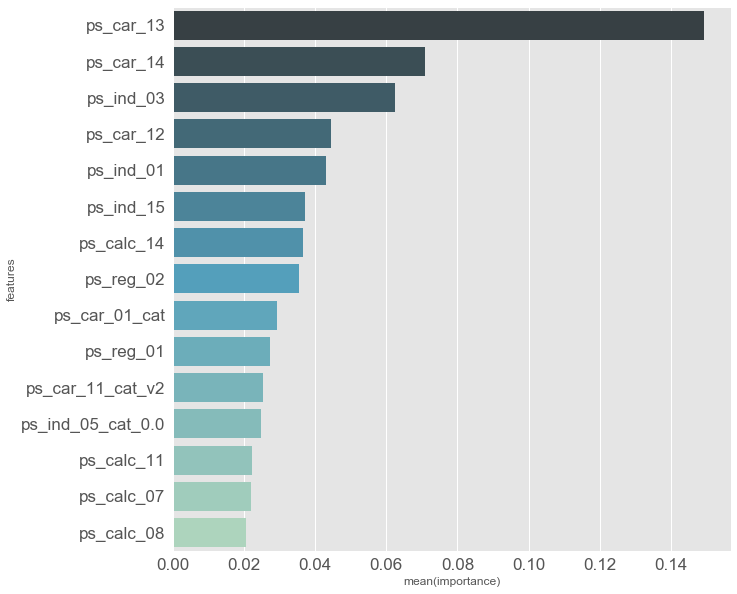

In [69]:
features_importance (GB_3, X_train_2, 15)

### Export das pr Análise de Recall e Precision

In [79]:
y_test_export = y_test.reset_index(drop=True)
base = pd.concat([ pd.DataFrame(GB_3.predict_proba(X_test_final_2)[:,1]), pd.DataFrame(y_test_export)], axis = 1)
base.columns=['prob', 'target']
base.to_csv('info.csv', index=False, decimal = ',', sep=';')

### Light GBM versão 2

In [38]:
import lightgbm as lgb

X_train_3, X_valid_2, y_train_3, y_valid_2 = train_test_split(X_train_2, y_train, test_size=0.15, random_state = 12)

d_train = lgb.Dataset(X_train_3, label=y_train_3)
d_valid = lgb.Dataset(X_valid_2, label=y_valid_2) 


#Split
watchlist = [d_train, d_valid]
def gini_normalized2(a, p):
    return gini(a, p) / gini(a, a)

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized2(labels, preds)
    return 'gini', gini_score, False


params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 60,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'learning_rate': 0.05,
    'max_depth': 7,
    'verbose': 0
}



print('Training LGBM model...')
model = lgb.train(params, train_set=d_train, num_boost_round=100, valid_sets=watchlist, 
early_stopping_rounds=100, verbose_eval=10, feval=gini_lgb)
print("End training")
 

Training LGBM model...
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.657418	training's gini: 0.314836	valid_1's auc: 0.623546	valid_1's gini: 0.247092
[20]	training's auc: 0.668218	training's gini: 0.336436	valid_1's auc: 0.63152	valid_1's gini: 0.26304
[30]	training's auc: 0.675982	training's gini: 0.351963	valid_1's auc: 0.633549	valid_1's gini: 0.267098
[40]	training's auc: 0.682611	training's gini: 0.365223	valid_1's auc: 0.635389	valid_1's gini: 0.270777
[50]	training's auc: 0.688792	training's gini: 0.377583	valid_1's auc: 0.636518	valid_1's gini: 0.273037
[60]	training's auc: 0.695264	training's gini: 0.390529	valid_1's auc: 0.637253	valid_1's gini: 0.274506
[70]	training's auc: 0.701842	training's gini: 0.403683	valid_1's auc: 0.637751	valid_1's gini: 0.275503
[80]	training's auc: 0.708254	training's gini: 0.416508	valid_1's auc: 0.638412	valid_1's gini: 0.276823
[90]	training's auc: 0.714651	training's gini: 0.429301	valid_1's auc: 0.638

In [39]:
print 'Resultado na base teste:'
#dtest = lgb.Dataset(X_test_final, label=y_test) 
probs = model.predict(X_test_final_2)
gini_normalized2(y_test, probs)

Resultado na base teste:


0.25987991222147361

### Extreme Gradient Boosting 2

In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param = {
  #  'objective' : 'binary:logistic',
    'min_child_weight' : [1, 5, 10],
   # 'silent' : True,
    'max_depth' : [3, 5, 8],
    'gamma' : [0.1, 1, 10]
    
}

folds = 5
param_comb = 12
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 100, objective='binary:logistic', silent = True, nthread = 1)
skf = StratifiedKFold(n_splits=folds, random_state = 1001)
scorer = make_scorer(gini_normalized, needs_proba=True)

random_search = RandomizedSearchCV(xgb, param_distributions=param, n_iter = param_comb, scoring=scorer, cv=skf, verbose=3, random_state=1001)

start = time()
xgboost_model = random_search.fit(X_train_2, y_train)
xgboost_model
end = time()

print "Best score:" , xgboost_model.best_score_
print "Best parameters:" , xgboost_model.best_params_
print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.220680, total= 1.5min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.227214, total= 1.4min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.246362, total= 1.4min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.224205, total= 1.4min
[CV] gamma=10, max_depth=3, min_child_weight=5 .......................
[CV]  gamma=10, max_depth=3, min_child_weight=5, score=0.227227, total= 1.5min
[CV] gamma=1, max_depth=3, min_child_weight=10 .......................
[CV]  gamma=1, max_depth=3, min_child_weight=10, score=0.221183, total= 1.5min
[CV] gamma=1, max_depth=3, min_child_weight=10 .......................
[CV]  gamma=1, max_depth=3, min_child_weight=10, score=0.227506, total= 1.4min
[CV] gamma=1, max_depth=3, min_child_weight=10 .......................
[CV]  gamma=1, max_depth=3, min_child_weight=10, score=0.247118, total= 1.5min
[CV] gamma=1, max_depth=3, min_child_weight=10 .......................
[CV]  gamma=1, max_depth=3, min_child_weight=10, score=0.224336, total= 1.6min
[CV] gamma=1, max_dep

[CV]  gamma=0.1, max_depth=8, min_child_weight=1, score=0.275478, total= 3.8min
[CV] gamma=0.1, max_depth=8, min_child_weight=1 ......................
[CV]  gamma=0.1, max_depth=8, min_child_weight=1, score=0.244387, total= 3.8min
[CV] gamma=0.1, max_depth=8, min_child_weight=1 ......................
[CV]  gamma=0.1, max_depth=8, min_child_weight=1, score=0.256585, total= 3.8min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 141.7min finished


Best score: 0.255695873182
Best parameters: {'gamma': 1, 'max_depth': 8, 'min_child_weight': 1}
Find best parameterers in 8808.3400 seconds.


In [41]:
print 'Resultado na base teste:'
gini_normalized(y_test, xgboost_model.predict_proba(X_test_final_2))

Resultado na base teste:


0.24782252927633616